In [1]:
import dynamo as dyn
import scvelo as scv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
dyn.configuration.set_figure_params('dynamo', background='white') # jupter notebooks


In [2]:
import re
import os
from pathlib import Path
from subprocess import run, PIPE, CalledProcessError
from typing import NamedTuple, List, Union, Optional

def get_version(package: Union[Path, str]) -> str:
    """Get the version of a package or module
    Pass a module path or package name.
    The former is recommended, since it also works for not yet installed packages.
    Supports getting the version from
    #. The directory name (as created by ``setup.py sdist``)
    #. The output of ``git describe``
    #. The package metadata of an installed package
       (This is the only possibility when passing a name)
    Args:
       package: package name or module path (``…/module.py`` or ``…/module/__init__.py``)
    """
    path = Path(package)
    if not path.suffix and len(path.parts) == 1:  # Is probably not a path
        v = get_version_from_metadata(package)
        if v:
            return str(v)

    if path.suffix != ".py":
        msg = f"“package” is neither the name of an installed module nor the path to a .py file."
        if path.suffix:
            msg += f" Unknown file suffix {path.suffix}"
        raise ValueError(msg)
    if path.name == "__init__.py":
        name = path.parent.name
        parent = path.parent.parent
    else:
        name = path.with_suffix("").name
        parent = path.parent

    return str(
        get_version_from_dirname(name, parent)
        or get_version_from_git(parent)
        or get_version_from_metadata(name, parent)
        or "0.0.0"
    )


def get_all_dependencies_version(display=True,package_name = "dynamo"):
    """
    Adapted from answer 2 in
    https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
    """
    import pkg_resources
    from IPython.display import display
    import pandas as pd

    
    _package = pkg_resources.working_set.by_key[package_name]

    all_dependencies = [
        str(r).split(">")[0] for r in _package.requires()
    ]  # retrieve deps from setup.py
    all_dependencies.sort(reverse=True)
    all_dependencies.insert(0, "dynamo-release")

    all_dependencies_list = []

    for m in pkg_resources.working_set:
        if m.project_name.lower() in all_dependencies:
            all_dependencies_list.append([m.project_name, m.version])

    df = (
        pd.DataFrame(
            all_dependencies_list[::-1], columns=["package", "version"]
        )
        .set_index("package")
        .T
    )

    if display:
        pd.options.display.max_columns = None
        display(df)
    else:
        return df
get_all_dependencies_version(package_name = "dynamo")

package colorcet hdbscan  joblib loompy matplotlib networkx   numba  \
version    2.0.6  0.8.27  0.17.0  3.0.6      3.4.1      2.5  0.51.2   

package numdifftools   numpy pandas pynndescent python-igraph scikit-learn  \
version       0.9.39  1.19.1  1.2.4       0.5.2         0.9.1       0.23.2   

package  scipy seaborn           setuptools statsmodels    tqdm umap-learn  \
version  1.5.2  0.11.0  50.3.0.post20201006      0.12.2  4.50.2      0.5.1   

package cvxopt  trimap  
version  1.2.6  1.0.15

In [10]:
adata = dyn.read_loom("data/looms/sorted_merged.loom")

In [9]:
dyn.pp.recipe_monocle(adata)

|-----> apply Monocole recipe to adata...


AttributeError: 'PandasArray' object has no attribute '_str_startswith'

## Learn dynamics

Next you will want to estimate the kinetic parameters of expression dynamics and then learn the velocity values for all genes that pass some filters (selected feature genes, by default) across cells. The `dyn.tl.dynamics` does all the hard work for you:


implicitly calls `dyn.tl.moments` first

`dyn.tl.moments(adata)`
which calculates the first, second moments (and sometimes covariance between different layers) of the expression data. First / second moments are basically mean and uncentered variance of gene expression, which are calculated based on local smoothing via a nearest neighbours graph, constructed in the reduced PCA space from the spliced or total mRNA expression of single cells.

And it then performs the following steps:

checks the data you have and determine the experimental type automatically, either the conventional scRNA-seq, kinetics, degradation or one-shot single-cell metabolic labelling experiment or the CITE-seq or REAP-seq co-assay, etc.

learns the velocity for each feature gene using either the original deterministic model based on a steady-state assumption from the seminal RNA velocity work or a few new methods, including the stochastic (default) or negative binomial method for conventional scRNA-seq or kinetic, degradation or one-shot models for metabolic labeling based scRNA-seq.

Those later methods are based on moment equations. All those methods use all or part of the output from `dyn.tl.moments(adata)`.

In [ ]:
dyn.tl.dynamics(adata)

In [ ]:
dyn.tl.reduceDimension(adata, basis='umap')

In [ ]:
dyn.tl.reduceDimension(adata, basis='pca')

In [ ]:
dyn.tl.cell_velocities(adata)

You can check the confidence of cell-wise velocity to understand how reliable the recovered velocity is across cells via:

In [ ]:
dyn.tl.cell_wise_confidence(adata)

## Vector field reconstruction

In classical physics, including fluidics and aerodynamics, velocity and acceleration vector fields are used as fundamental tools to describe motion or external force of objects, respectively. In analogy, RNA velocity or protein accelerations estimated from single cells can be regarded as sparse samples in the velocity (La Manno et al. 2018) or acceleration vector field (Gorin, Svensson, and Pachter 2019) that defined on the gene expression space.

In general, a vector field can be defined as a vector-valued function f that maps any points (or cells’ expression state) x in a domain Ω with D dimension (or the gene expression system with D transcripts / proteins) to a vector y (for example, the velocity or acceleration for different genes or proteins), that is f(x) = y.

To formally define the problem of velocity vector field learning, we consider a set of measured cells with pairs of current and estimated future expression states. The difference between the predicted future state and current state for each cell corresponds to the velocity vector. We note that the measured single-cell velocity (conventional RNA velocity) is sampled from a smooth, differentiable vector field f that maps from xi to yi on the entire domain. Normally, single cell velocity measurements are results of biased, noisy and sparse sampling of the entire state space, thus the goal of velocity vector field reconstruction is to robustly learn a mapping function f that outputs yj given any point xj on the domain based on the observed data with certain smoothness constraints (Jiayi Ma et al. 2013). Under ideal scenario, the mapping function f should recover the true velocity vector field on the entire domain and predict the true dynamics in regions of expression space that are not sampled. To reconstruct vector field function in dynamo, you can simply use the following function to do all the heavy-lifting:

In [ ]:
dyn.vf.VectorField(adata, basis='umap')

By default, it learns the vector field in the pca space but you can of course learn it in any space or even the original gene expression space.

## Characterize vector field topology

Since we learn the vector field function of the data, we can then characterize the topology of the full vector field space. For example, we are able to identify

the fixed points (attractor/saddles, etc.) which may corresponds to terminal cell types or progenitors;

nullcline, separatrices of a recovered dynamic system, which may formally define the dynamical behaviour or the boundary of cell types in gene expression space.

Again, you only need to simply run the following function to get all those information.

In [ ]:
dyn.vf.topography(adata, basis='umap')


## Map potential landscape

The concept of potential landscape is widely appreciated across various biological disciplines, for example the adaptive landscape in population genetics, protein-folding funnel landscape in biochemistry, epigenetic landscape in developmental biology. In the context of cell fate transition, for example, differentiation, carcinogenesis, etc, a potential landscape will not only offers an intuitive description of the global dynamics of the biological process but also provides key insights to understand the multi-stability and transition rate between different cell types as well as to quantify the optimal path of cell fate transition.

Because the classical definition of potential function in physics requires gradient systems (no curl or cycling dynamics), which is often not applicable to open biological system. In dynamo we provided several ways to quantify the potential of single cells by decomposing the vector field into gradient, curl parts, etc. The recommended method is built on the Hodge decomposition on simplicial complexes (a sparse directional graph) constructed based on the learned vector field function that provides fruitful analogy of gradient, curl and harmonic (cyclic) flows on manifold:

In [ ]:
dyn.ext.ddhodge(adata)

In [ ]:
dyn.pl.cell_wise_vectors(adata, color="orig.ident", ncols=3)


In [ ]:
dyn.pl.grid_vectors(adata, color="orig.ident", ncols=3)


In [ ]:
dyn.pl.streamline_plot(adata, color="orig.ident", ncols=3)


In [ ]:
dyn.pl.streamline_plot(adata, color="cluster")


In [ ]:
dyn.pl.topography(adata,sym_c = True,contour = True)

In [ ]:
dyn.pd.fate(adata, basis='umap', init_cells = [0])

In [ ]:
dyn.cleanup(adata)
adata.write_h5ad("dynamo.h5ad")

In [3]:
adata = dyn.read_h5ad("dynamo.h5ad")

In [4]:
from matplotlib import animation, rc
from IPython.display import HTML, Image
#dyn.mv.StreamFuncAnim(adata, basis = 'umap')

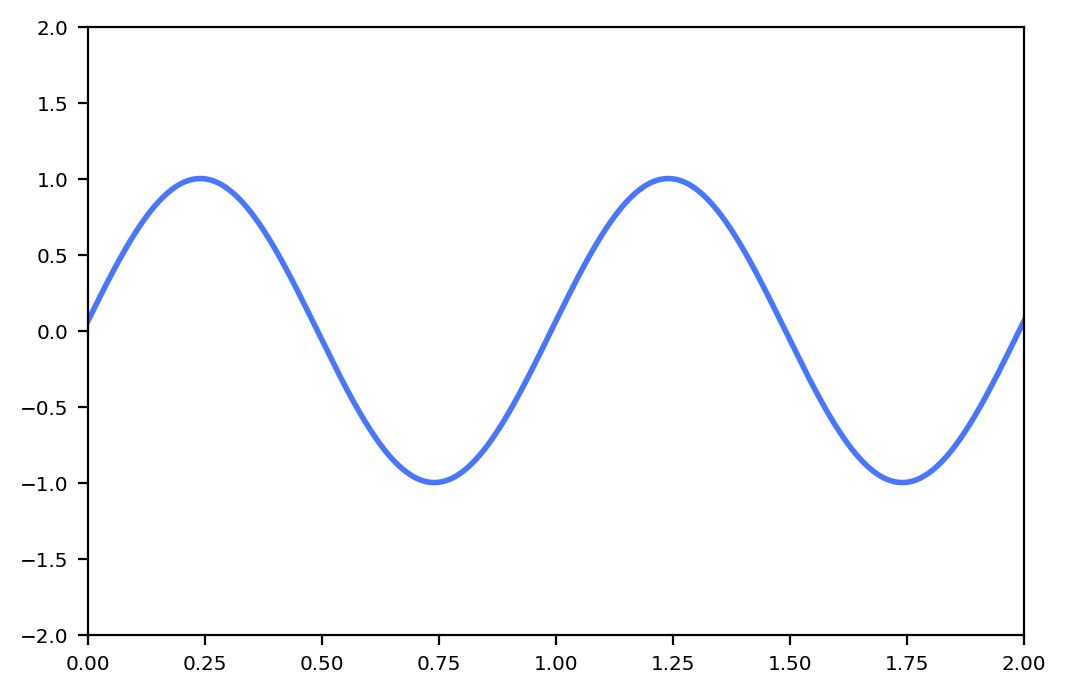

In [7]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)
# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)
# call the animator. blit=True means only re-draw the parts that 
# have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
HTML(anim.to_jshtml())

In [ ]:
fig1, f1_axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(12, 10))
f1_axes
f1_axes[0, 0] = dyn.pl.cell_wise_vectors(adata, color='orig.ident', pointsize=0.1, alpha = 0.7, ax=f1_axes[0, 0], quiver_length=6, quiver_size=6, save_show_or_return='return')
#f1_axes[0, 1] = dyn.pl.grid_vectors(adata, color='speed_umap', ax=f1_axes[0, 1], quiver_length=12, quiver_size=12, save_show_or_return='return')
#f1_axes[1, 0] = dyn.pl.streamline_plot(adata, color='divergence_pca', ax=f1_axes[1, 0], save_show_or_return='return')
f1_axes[1, 1] = dyn.pl.topography(adata, color='acceleration_umap', ax=f1_axes[1, 1], save_show_or_return='return')
plt.show()